In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/Users/ohheungchan/workspace/AI_Study/Paperwork/human+activity+recognition+using+smartphones/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/Users/ohheungchan/workspace/AI_Study/Paperwork/human+activity+recognition+using+smartphones/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:

print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:

print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:

unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)
     

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)
     

In [9]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]
     

In [10]:
from tensorflow.keras.layers import LSTM
model = Sequential()
model.add(Bidirectional(LSTM(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()
     

Metal device set to: Apple M2 Pro


2024-03-27 00:56:38.664021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-27 00:56:38.664447: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              141312    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 158,150
Trainable params: 158,150
Non-trainable params: 0
_________________________________________________________________


In [12]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10
58/58 [==============================] - 6s 100ms/step - loss: 0.1498 - accuracy: 0.9425 - val_loss: 0.1299 - val_accuracy: 0.9519
Epoch 2/10
58/58 [==============================] - 6s 99ms/step - loss: 0.1671 - accuracy: 0.9399 - val_loss: 0.1557 - val_accuracy: 0.9479
Epoch 3/10
58/58 [==============================] - 6s 98ms/step - loss: 0.1804 - accuracy: 0.9336 - val_loss: 0.2379 - val_accuracy: 0.9189
Epoch 4/10
58/58 [==============================] - 6s 97ms/step - loss: 0.2346 - accuracy: 0.9219 - val_loss: 0.1442 - val_accuracy: 0.9461
Epoch 5/10
58/58 [==============================] - 6s 97ms/step - loss: 0.1405 - accuracy: 0.9484 - val_loss: 0.1271 - val_accuracy: 0.9542
Epoch 6/10
58/58 [==============================] - 6s 97ms/step - loss: 0.1539 - accuracy: 0.9437 - val_loss: 0.1205 - val_accuracy: 0.9587
Epoch 7/10
58/58 [==============================] - 6s 96ms/step - loss: 0.1448 - accuracy: 0.9448 - val_loss: 0.1220 - val_accuracy: 0.9551
Epoch 8/10
5

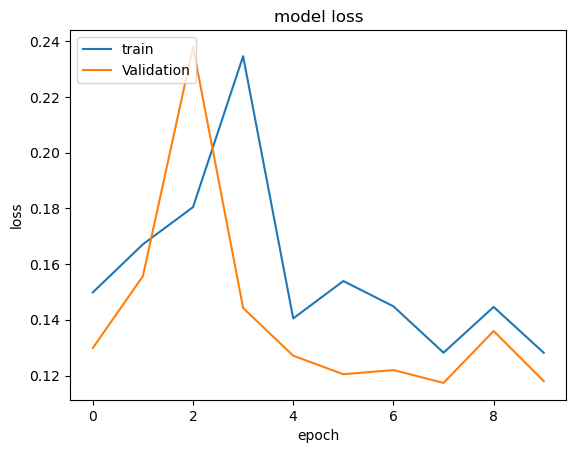

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

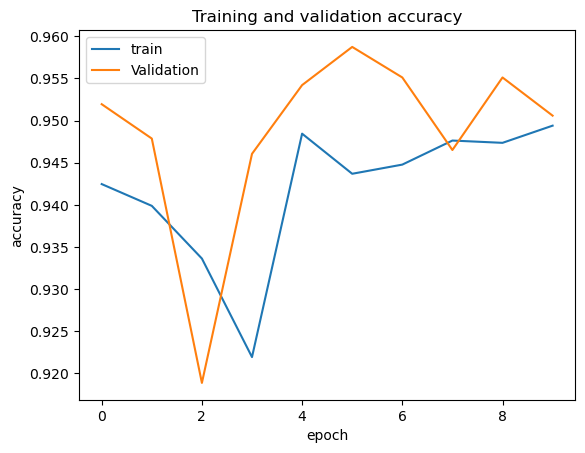

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2024-03-27 01:07:58.702877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:07:58.783267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:07:58.796322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 9s 72ms/step
[[450  19  22   5   0   0]
 [  8 461   1   0   1   0]
 [  1   3 416   0   0   0]
 [  0   1   0 376 114   0]
 [  1   1   0  63 467   0]
 [  0   0   0   0   0 537]]
0.9185612487275195
0.9181992520402416
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       496
           1       0.95      0.98      0.96       471
           2       0.95      0.99      0.97       420
           3       0.85      0.77      0.80       491
           4       0.80      0.88      0.84       532
           5       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

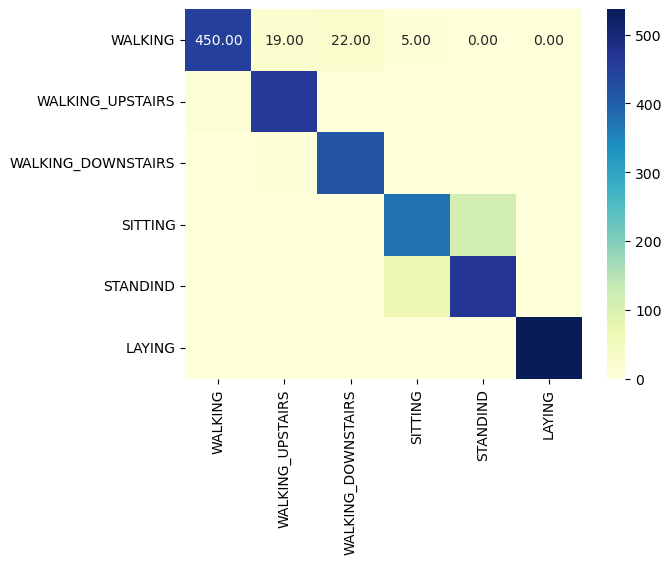

In [15]:

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [16]:

from tensorflow.keras.layers import LSTM
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 128, 256)         141312    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 6)                

In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10


2024-03-27 01:08:29.727457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:08:30.145985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:08:30.159939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:08:31.793710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:08:31.809499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:08:33.523041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:08:33.542103: I tensorflow/core/grappler/optimizers/cust

58/58 [==============================] - ETA: 0s - loss: 1.0372 - accuracy: 0.5566

2024-03-27 01:09:25.097506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:09:25.252149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:09:25.260968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:09:26.756174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:09:26.768132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 66s 688ms/step - loss: 1.0372 - accuracy: 0.5566 - val_loss: 0.6727 - val_accuracy: 0.7267
Epoch 2/10
58/58 [==============================] - 11s 192ms/step - loss: 0.5099 - accuracy: 0.8100 - val_loss: 0.4682 - val_accuracy: 0.8459
Epoch 3/10
58/58 [==============================] - 11s 189ms/step - loss: 0.6998 - accuracy: 0.7297 - val_loss: 0.7996 - val_accuracy: 0.6868
Epoch 4/10
58/58 [==============================] - 11s 190ms/step - loss: 0.5437 - accuracy: 0.7773 - val_loss: 0.3854 - val_accuracy: 0.8386
Epoch 5/10
58/58 [==============================] - 11s 189ms/step - loss: 0.3479 - accuracy: 0.8754 - val_loss: 0.3401 - val_accuracy: 0.8676
Epoch 6/10
58/58 [==============================] - 11s 190ms/step - loss: 0.2892 - accuracy: 0.8951 - val_loss: 0.2056 - val_accuracy: 0.9311
Epoch 7/10
58/58 [==============================] - 11s 190ms/step - loss: 0.1750 - accuracy: 0.9346 - val_loss: 0.1567 - val_accuracy: 0.9338
Epoch 8/10

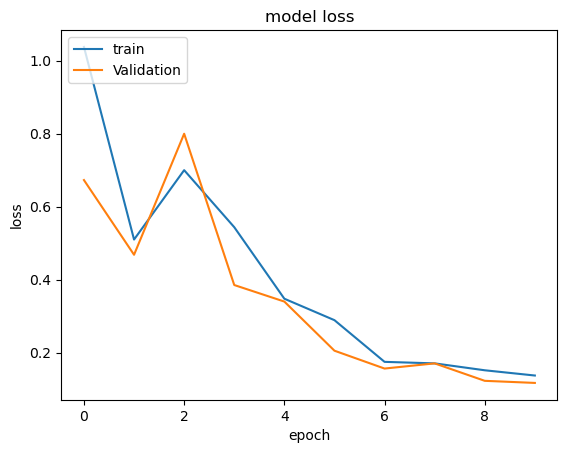

In [18]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
     

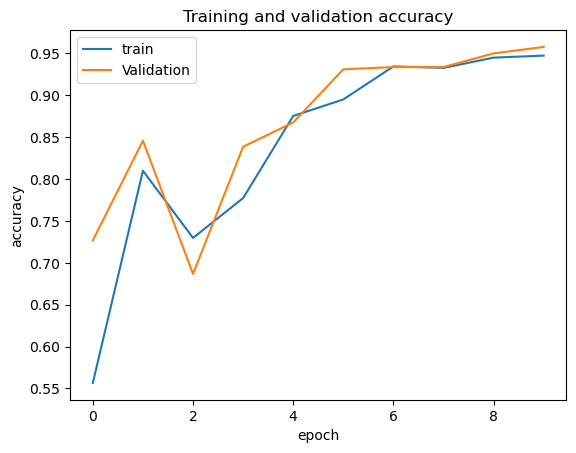

In [19]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2024-03-27 01:12:14.131610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:12:14.268475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:12:14.277779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:12:15.805051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:12:15.814977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 15s 117ms/step
[[454   5  37   0   0   0]
 [  6 454  11   0   0   0]
 [  0   0 420   0   0   0]
 [  1   6   0 379 105   0]
 [  2   0   0  84 446   0]
 [  0  27   0   0   0 510]]
0.9036308109942314
0.9034511367563268
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       496
           1       0.92      0.96      0.94       471
           2       0.90      1.00      0.95       420
           3       0.82      0.77      0.79       491
           4       0.81      0.84      0.82       532
           5       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.91      0.90      2947
weighted avg       0.91      0.90      0.90      2947



<Axes: >

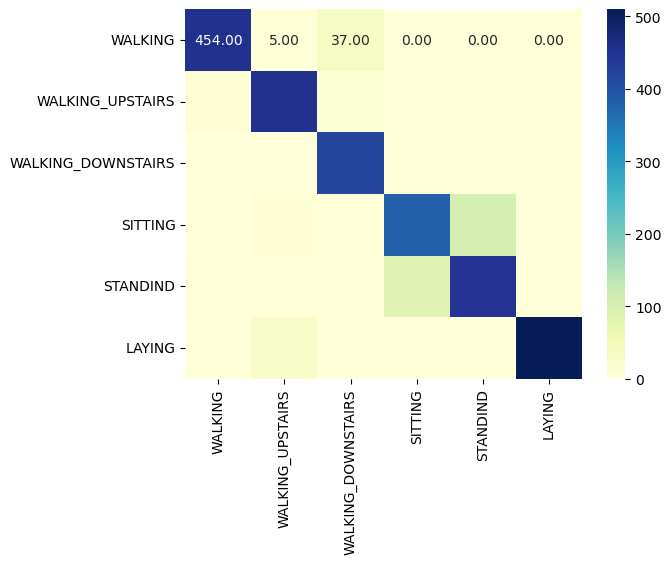

In [20]:

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [21]:
from tensorflow.keras.layers import LSTM
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 128, 256)         141312    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 128, 256)         394240    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                      

In [22]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     


Epoch 1/10


2024-03-27 01:12:43.807809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:12:44.428626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:12:44.446130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:12:45.977321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:12:46.027500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:12:47.587910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:12:47.607079: I tensorflow/core/grappler/optimizers/cust

58/58 [==============================] - ETA: 0s - loss: 0.9908 - accuracy: 0.5721

2024-03-27 01:14:05.835025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:14:06.061086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:14:06.061108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:14:07.600291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:14:07.612980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:14:09.153219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:14:09.163393: I tensorflow/core/grappler/optimizers/cust

58/58 [==============================] - 98s 1s/step - loss: 0.9908 - accuracy: 0.5721 - val_loss: 0.6710 - val_accuracy: 0.7162
Epoch 2/10
58/58 [==============================] - 17s 287ms/step - loss: 0.5447 - accuracy: 0.7681 - val_loss: 0.5143 - val_accuracy: 0.7788
Epoch 3/10
58/58 [==============================] - 17s 287ms/step - loss: 0.3883 - accuracy: 0.8531 - val_loss: 0.2521 - val_accuracy: 0.8985
Epoch 4/10
58/58 [==============================] - 16s 285ms/step - loss: 0.2205 - accuracy: 0.9184 - val_loss: 0.1584 - val_accuracy: 0.9429
Epoch 5/10
58/58 [==============================] - 17s 288ms/step - loss: 0.1694 - accuracy: 0.9327 - val_loss: 0.1319 - val_accuracy: 0.9542
Epoch 6/10
58/58 [==============================] - 17s 301ms/step - loss: 0.1616 - accuracy: 0.9372 - val_loss: 0.1267 - val_accuracy: 0.9497
Epoch 7/10
58/58 [==============================] - 17s 294ms/step - loss: 0.1375 - accuracy: 0.9453 - val_loss: 0.1187 - val_accuracy: 0.9560
Epoch 8/10
58

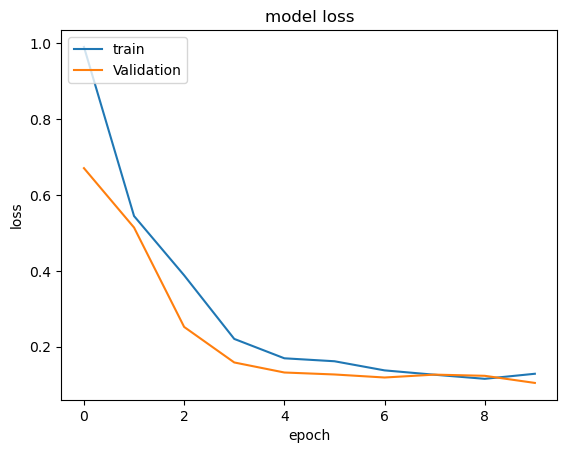

In [23]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

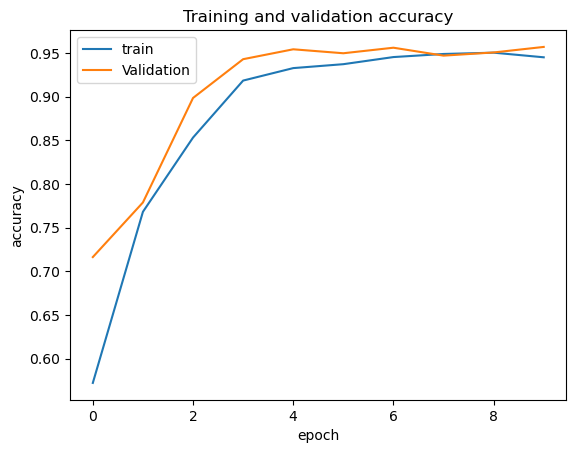

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2024-03-27 01:20:41.613676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:20:41.817229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:20:41.826836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:20:43.370776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:20:43.380557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:20:44.905585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:20:44.914930: I tensorflow/core/grappler/optimizers/cust

93/93 [==============================] - 21s 170ms/step
[[469   0  27   0   0   0]
 [ 13 431  27   0   0   0]
 [  0   0 420   0   0   0]
 [  0  19   1 416  50   5]
 [  4   0   0 111 417   0]
 [  0  15   0   0   0 522]]
0.9077027485578555
0.9073823144899138
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       496
           1       0.93      0.92      0.92       471
           2       0.88      1.00      0.94       420
           3       0.79      0.85      0.82       491
           4       0.89      0.78      0.83       532
           5       0.99      0.97      0.98       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

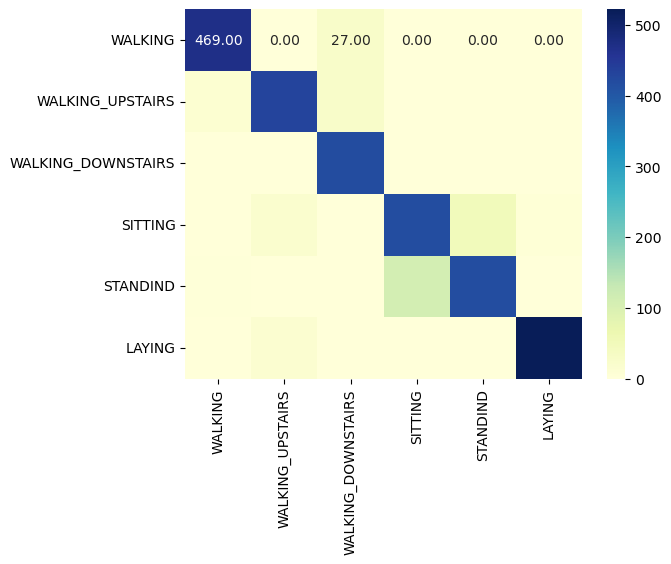

In [25]:

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [26]:

from tensorflow.keras.layers import LSTM
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 128, 256)         141312    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 128, 256)         394240    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 128, 256)         394240    
 nal)                                                            
                                                      

In [27]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10


2024-03-27 01:21:44.496940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:21:45.299678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:21:45.313531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:21:46.850648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:21:46.891369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:21:48.520780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:21:48.539834: I tensorflow/core/grappler/optimizers/cust

58/58 [==============================] - ETA: 0s - loss: 1.0033 - accuracy: 0.5653

2024-03-27 01:23:34.994304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:23:35.283881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:23:35.292409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:23:36.819633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:23:36.831712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:23:38.327567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:23:38.338002: I tensorflow/core/grappler/optimizers/cust

58/58 [==============================] - 131s 1s/step - loss: 1.0033 - accuracy: 0.5653 - val_loss: 0.7162 - val_accuracy: 0.6931
Epoch 2/10
58/58 [==============================] - 23s 390ms/step - loss: 0.6092 - accuracy: 0.7393 - val_loss: 0.5475 - val_accuracy: 0.7833
Epoch 3/10
58/58 [==============================] - 23s 389ms/step - loss: 0.4752 - accuracy: 0.8022 - val_loss: 0.3896 - val_accuracy: 0.8400
Epoch 4/10
58/58 [==============================] - 22s 387ms/step - loss: 0.3199 - accuracy: 0.8781 - val_loss: 0.2456 - val_accuracy: 0.9121
Epoch 5/10
58/58 [==============================] - 22s 388ms/step - loss: 0.1909 - accuracy: 0.9313 - val_loss: 0.1942 - val_accuracy: 0.9243
Epoch 6/10
58/58 [==============================] - 23s 391ms/step - loss: 0.1646 - accuracy: 0.9347 - val_loss: 0.1287 - val_accuracy: 0.9501
Epoch 7/10
58/58 [==============================] - 23s 393ms/step - loss: 0.1754 - accuracy: 0.9300 - val_loss: 0.1247 - val_accuracy: 0.9519
Epoch 8/10
5

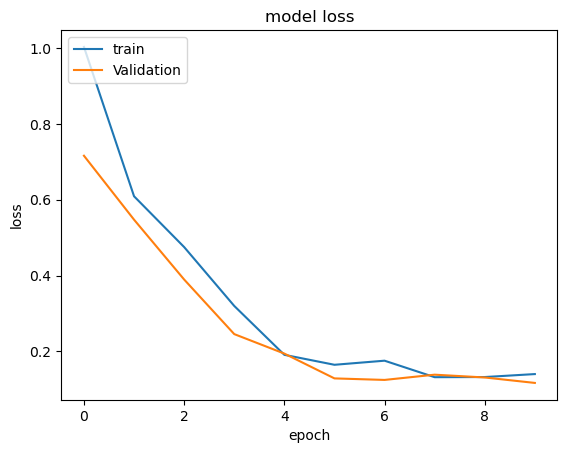

In [28]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

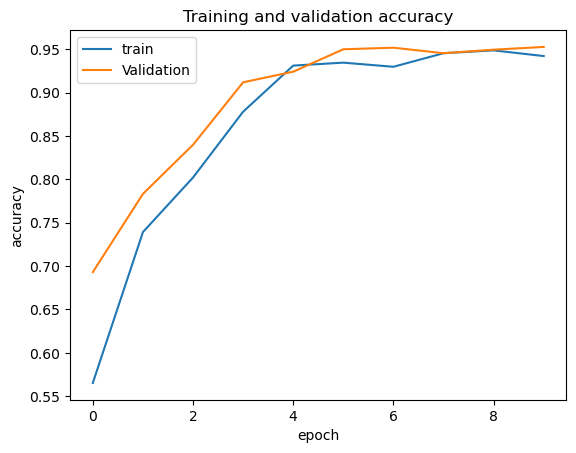

In [29]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
     

2024-03-27 01:45:00.896065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:45:01.183325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:45:01.198281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:45:02.755352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:45:02.765951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:45:04.263907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-27 01:45:04.273507: I tensorflow/core/grappler/optimizers/cust

93/93 [==============================] - 30s 241ms/step
[[431   0  45   0  20   0]
 [  2 441  26   0   1   1]
 [  0   0 420   0   0   0]
 [  0   2   0 385 103   1]
 [  2   0   0  95 435   0]
 [  0   0   0   0   0 537]]
0.8988802171700034
0.8994279276957478
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       496
           1       1.00      0.94      0.96       471
           2       0.86      1.00      0.92       420
           3       0.80      0.78      0.79       491
           4       0.78      0.82      0.80       532
           5       1.00      1.00      1.00       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

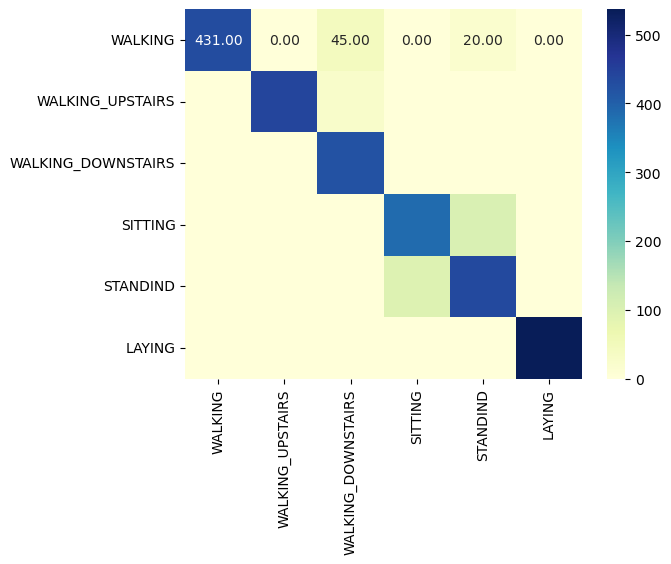

In [30]:

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')